# Predictor de accidente cerebrovascular

Este proyecto se centra en el desarrollo de una red neuronal capaz de predecir al probabilidad de sufrir un accidente cerebrobascular basándose en una variedad de características de los pacientes.
Se seleccionó una base de datos adecuada para el objetivo del proyecto, compuesta por los siguientes atributos:

1) id: Identificador único

2) gender: Género del paciente; "Male", "Female" y "Other"

3) age: Edad del paciente

4) hypertension: Si el paciente sufre de hipertensión arterial; 0 no, 1 sí

5) heart_disease: Si el paciente sufre algún tipo de enfermedad cardíaca; 0 no, 1 sí

6) ever_married: Si el paciente alguna vez estuvo casado; "No" o "Yes"

7) work_type: Tipo de trabajo que realiza el paciente; "children" si es un niño, "Govt_job" trabajador público, "Private" trabaja en el sector privado, "Never_worked" 
nunca trabajó.

8) Residence_type: Tipo de residencia; "Rural" o "Urban"

9) avg_glucose_level: Nivel promedio de glucosa en sangre.

10) bmi: Índice de masa corporal.

11) smoking_status: Actividad como fumador del paciente; "Unknown" no se sabe o no se obtuvo la información del paciente, "never smoked" nunca fumó, "formerly smoked" solía fumar, "smokes" fuma actualmente.

12) stroke: Si el paciente sufrió o no un accidente cerebrovascular: 0 no, 1 sí.

En el desarrollo del proyecto se realizará una evaluación inicial de los datos obtenidos en la base de datos, se realizará una remoción de los datos atípicos, se evaluará la correlación de los distintos datos con la presencia o no de un accidente cerebrovascular y finalmente teniendo en cuenta el análisis previamente realizado se desarrollará el modelo de red neuronal.

In [403]:
#Datos sacados de https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #Libería para visualización de datos estadísticos

## Visualización inicial de los datos

Se visualiza la composición del dataframe y se realizan gráficos específicamente histogramas para datos numéricos y gráficos de barras para datos categóricos, para tener un panorama inicial de los datos y evaular la presencia de valores atípicos.

In [404]:
df = pd.read_csv("https://raw.githubusercontent.com/joanavarro23/tp-mate3-red/main/mate3-red/acv.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


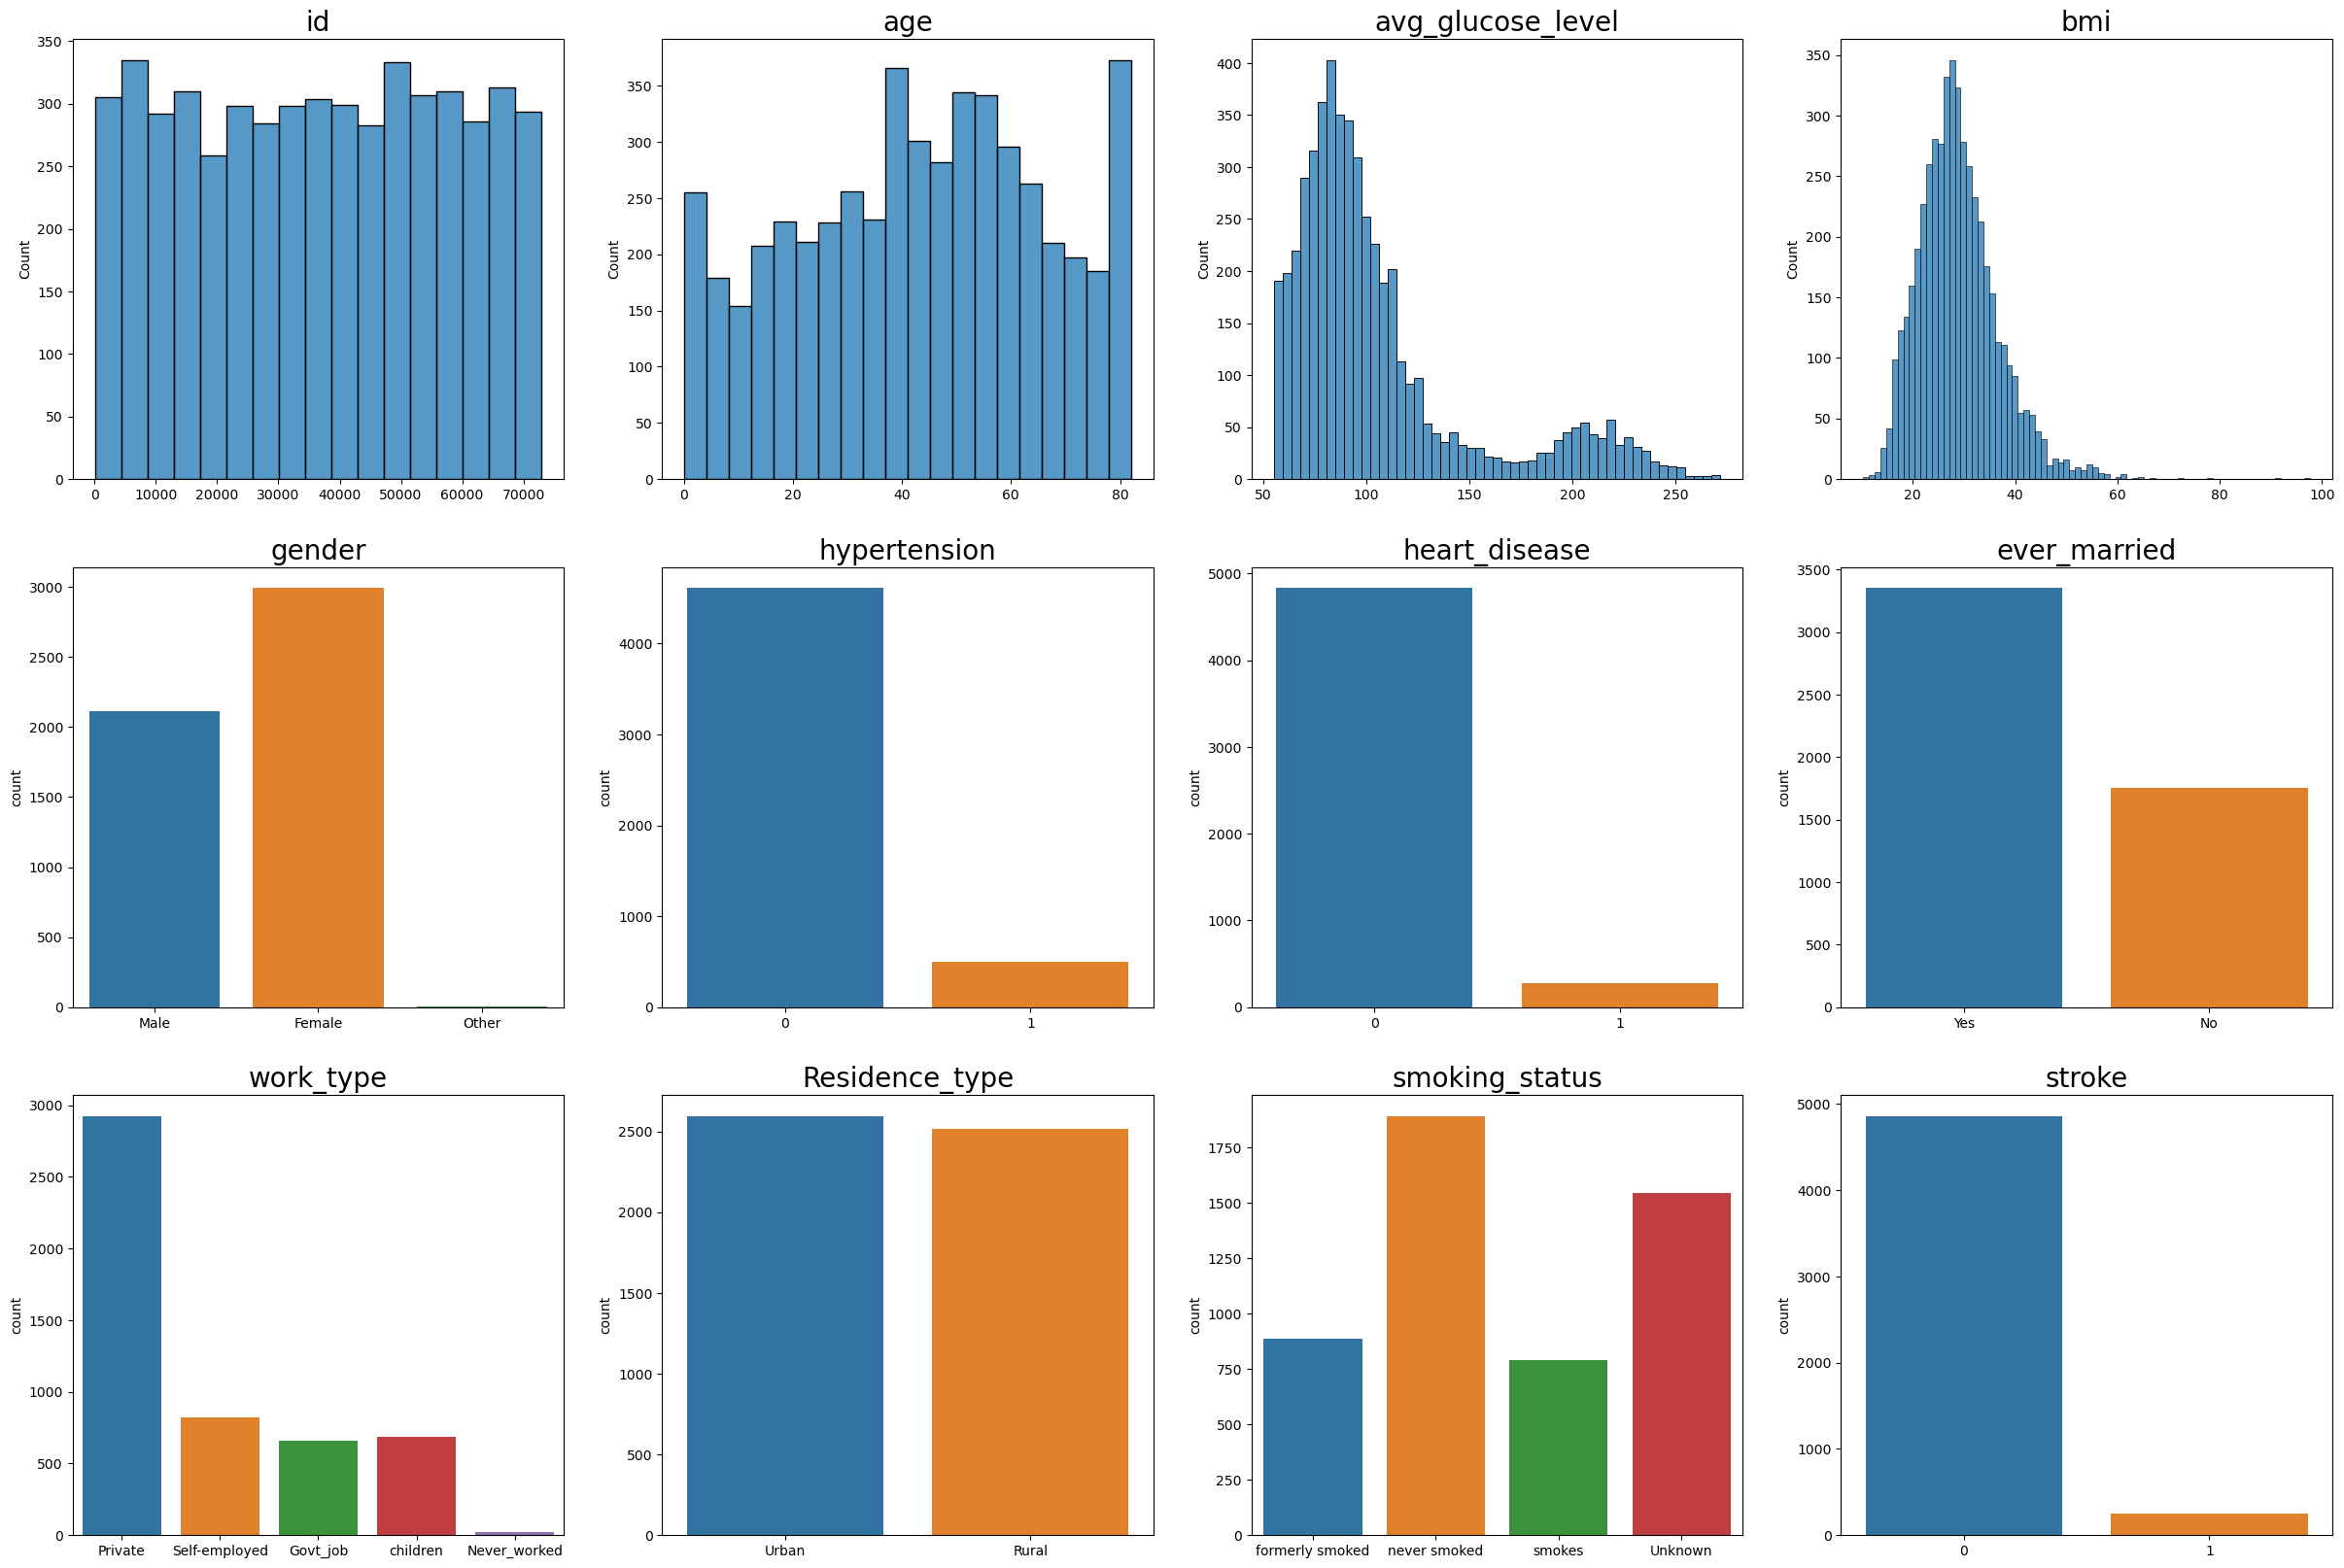

In [405]:

fig, ax = plt.subplots(3, 4) #3 filas 4 columnas
fig.set_size_inches(30, 20) #Tamaño de los gráficos

features = ['id', 'age', 'avg_glucose_level', 'bmi', 'gender', 'hypertension', 'heart_disease',
            'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke'] #Características a graficar
numerical_features = ['id', 'age', 'avg_glucose_level', 'bmi'] #Variables numéricas a graficar con histograma

for i, feature in enumerate(features):
    row = i // 4
    col = i % 4 #Ubicaicón de los gráficos
    if feature in numerical_features:
        hist = sns.histplot(data=df, x=feature, ax=ax[row, col])#Histograma para datos numéricos 
    else:
        hist = sns.countplot(data=df, x=feature, ax=ax[row, col]) #Gráfico de barras para datos categóricos
    hist.set_title(feature, fontsize=20)
    hist.set_xlabel('')
    
plt.show()

## Manejo de datos y remoción de valores atípicos

Después de visualización inicial de los datos, verificamos por la presencia de valores nulos en la base de datos donde encontramos 201 valores de índice de masa corporal no definidos, estos valores los completamos usando la función fillna de pandas y llenando estos valores nulos con la media de la columna 'bmi', luego también removemos la columna 'id' porque no será relevante para nuestro análisis, y removemos el caso de genéro 'other' ya que hay uno solo en toda la base de datos y no es suficiente para realizar un análisis estadístico.

Para el trato de valores atípicos tomamos los valores de nivel promedio de glucosa en sangre e índice de masa corporal, ya que vemos hacia los extremos más altos algunos valores atípicos en los histogramas, para esto usamos el método de la distancia intercuartílica, donde separamos nuestros datos en cuatriles y calculamos el rango intercuartílico para determinar el límite inferior y el límite superior de datos, los datos que se encuentren debajo del inferior o por encima del superior serán considerados atípicos.

In [406]:
print(df.isnull().sum()) #Chequeo presencia de valores nulos

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


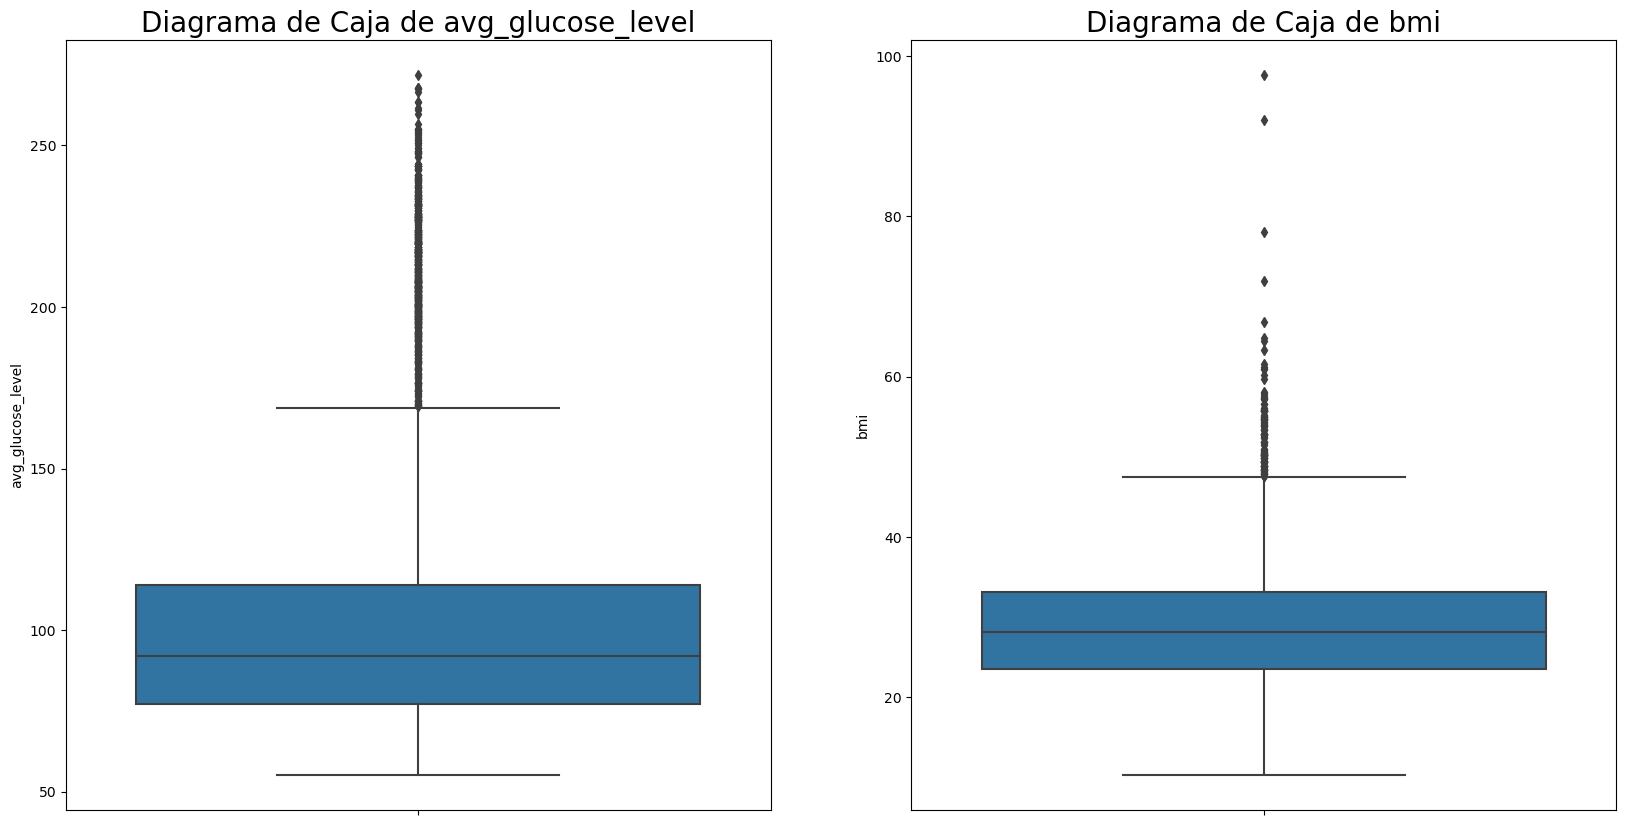

In [407]:
# Configurar el tamaño de la figura
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Lista de características a graficar
features = ['avg_glucose_level', 'bmi']

# Crear diagramas de caja para cada característica
for i, feature in enumerate(features):
    sns.boxplot(data=df, y=feature, ax=ax[i])
    ax[i].set_title(f'Diagrama de Caja de {feature}', fontsize=20)
    ax[i].set_xlabel('')

# Mostrar los gráficos
plt.show()

Se grafican diagramas de caja para visualizar la variabilidad de los datos sobre los que consideramos que hay mayor presencia de valores atípicos.

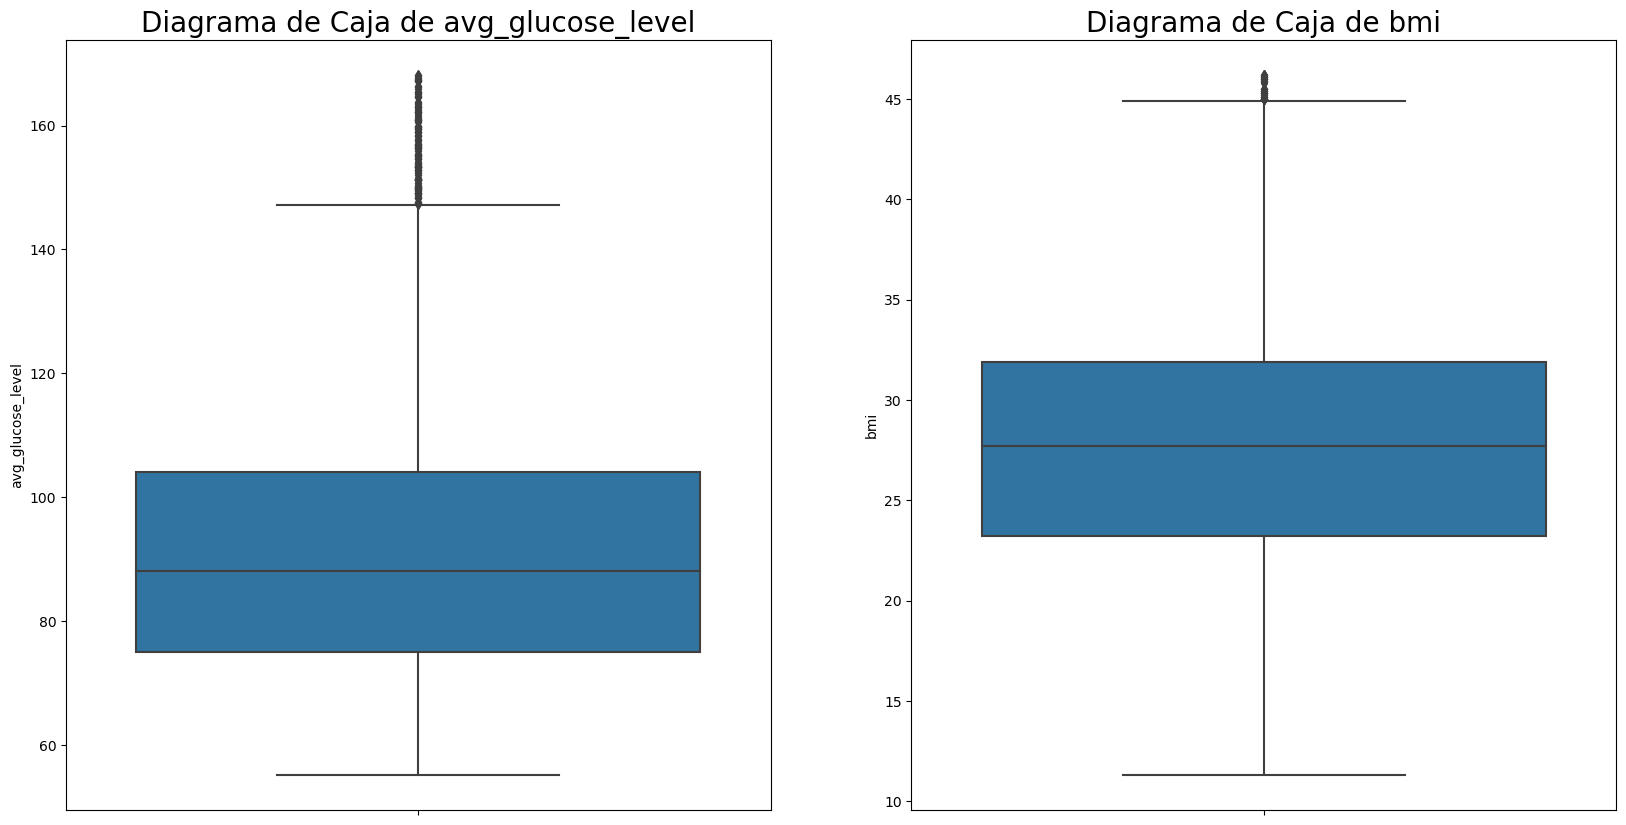

In [408]:
df['bmi'].fillna((round(df['bmi'].mean())), inplace=True) #Lleno los NaN del bmi con la media
df.drop("id", axis=1, inplace=True) #Elimíno columna id
df = df[df.gender != 'Other'] #Remuevo el género other porque hay 1 solo caso y no es estadísticamente relevante

def remover_valoresAtípicos_intercuartil(data, col): #Función para remover valores atípicos con método de distancia intercuatril
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    RIC = Q3 - Q1
    limite_inferior = Q1 - 1.5 * RIC
    limite_superior = Q3 + 1.5 * RIC
    return data[(data[col] >= limite_inferior) & (data[col] <= limite_superior)]

df = remover_valoresAtípicos_intercuartil(df, 'bmi')
df = remover_valoresAtípicos_intercuartil(df, 'avg_glucose_level')
#Saco los valores atípicos de índice de masa corporal y nivel promedio de glucosa ya que mirando los gráficos es donde se podrían encontrar en mayor cantidad

datos_a_graficar = ['avg_glucose_level', 'bmi']

# Configurar el tamaño de la figura
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Crear diagramas de caja para cada característica
for i, feature in enumerate(datos_a_graficar):
    sns.boxplot(data=df, y=feature, ax=ax[i])
    ax[i].set_title(f'Diagrama de Caja de {feature}', fontsize=20)
    ax[i].set_xlabel('')

# Mostrar los gráficos
plt.show()

Viendo los diagramas de caja después de utilizar nuestra función para remover los valores atípicos vemos como se reduce considerablemente la variabilidad de los datos.

## Análisis de datos
### Edad, nivel promedio de glucosa en sangre e índice de masa corporal

Para los datos numéricos se hizo una función, que agrupa los datos por intervalos y calcula la media del valor de salida, para de esta manera poder visualizar la correlación entre las distintas características y la ocurrencia de accidentes cerebrovasculares.

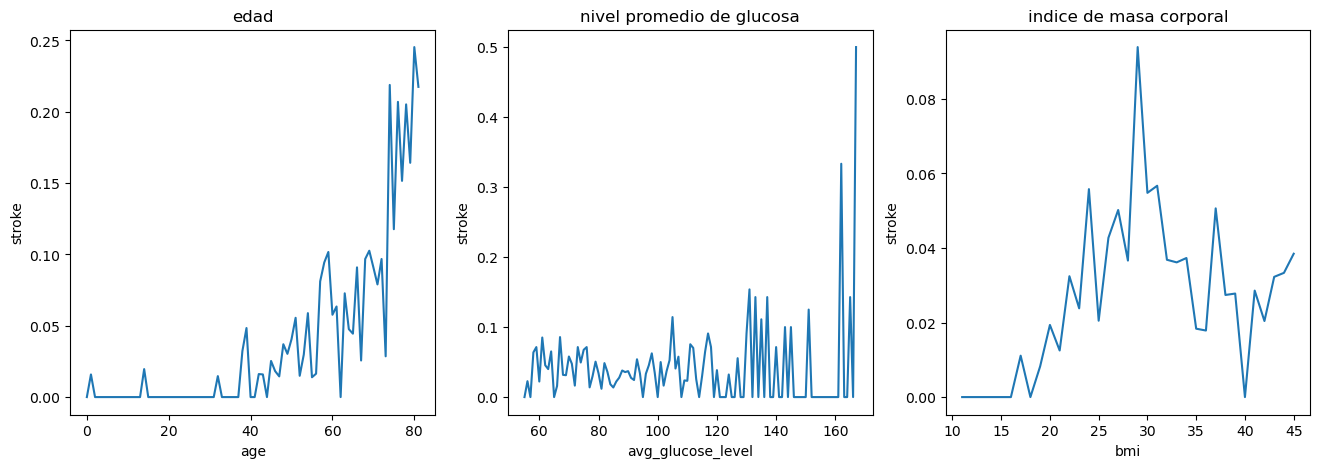

In [409]:
def get_grouped_stroke_mean_data(feature): #Función para agrupamiento de medias de datos numéricos y obtener su relación con mi dato de salida
    maximo = np.max(df[feature])
    minimo = np.min(df[feature]) #Maximo y minimo del dato de entrada para delimitar rango de trabajo
    grupo_media = np.array([])
    grupo = np.array([])

    for i in range(round(minimo), round(maximo)): #Se itera sobre el rango de la característica numérica
        i_data = df[(df[feature] >= (i - 0.5)) & (df[feature] < (i + 0.5))] #Agrupamiento de la característica en intervalos de 1
        grupo_media = np.append(grupo_media, np.mean(i_data['stroke'])) #Se calcula la media de stroke para el intervalo y se guarda en el array grupo_media
        grupo = np.append(grupo, i) #Se guarda el valor de i en el array grupo
    
    grupo_media = np.nan_to_num(grupo_media) #Se reemplazan los NaN por 0 en caso de que no hayan valores para el agrupamiento
    return grupo, grupo_media #Se retornan los valores del grupo y las medias de stroke

edad, edad_media = get_grouped_stroke_mean_data('age')
glucosa, glucosa_media = get_grouped_stroke_mean_data('avg_glucose_level')
bmi, bmi_media = get_grouped_stroke_mean_data('bmi')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(16, 5)

sns.lineplot(x=edad, y=edad_media, ax=ax[0]).set(xlabel='age', ylabel='stroke', title='edad')
sns.lineplot(x=glucosa, y=glucosa_media, ax=ax[1]).set(xlabel='avg_glucose_level', ylabel='stroke', title='nivel promedio de glucosa')
sns.lineplot(x=bmi, y=bmi_media, ax=ax[2]).set(xlabel='bmi', ylabel='stroke', title='indice de masa corporal')

plt.show()

En los datos numéricos donde se ve mayor correlación con la posibilidad de un accidente cerebrovascular es con la edad, tanto un mayor nivel de glucosa en sangre como un mayor índice de masa corporal parecen tener una mayor chance de accidente cerebrovascular, pero la correlación es menos clara.

## Datos categóricos

Para los datos categóricos, se crea una tabla de contingencia donde se ven los casos que sufrieron o no accidentes cerebrovasculares para cada categoría, y luego se normalizan los valores para distinguir en qué proporciones están distribuidos para cada caso.

### Hipertensión arterial

In [410]:
pd.crosstab(df.stroke, df.hypertension) #Tabla de contingencia entre stroke e hipertensión

hypertension,0,1
stroke,,
0,3935,289
1,128,37


In [411]:
pd.crosstab(df.stroke, df.hypertension, normalize='columns')

hypertension,0,1
stroke,,
0,0.968496,0.886503
1,0.031504,0.113497


De los casos de hipertensión se ve que hay una mayor proporción de pacientes con hipertensión que tienen más probabilidades de sufrir un ACV, alrededor de un 11.3% de los pacientes con hipertensión sufrieron un ACV, mientras que un 3.1% de los pacientes sin hipertensión sufrieron uno.

### Enfermedades cardíacas

In [412]:
pd.crosstab(df.stroke, df.heart_disease)

heart_disease,0,1
stroke,,
0,4073,151
1,144,21


In [413]:
pd.crosstab(df.stroke, df.heart_disease, normalize='columns')

heart_disease,0,1
stroke,,
0,0.965853,0.877907
1,0.034147,0.122093


En los casos que hay presencia de una enfermedad cardíaca es aún mayor la diferencia, alrededor de un 12.2% de los casos con enfermedad cardíaca sufrieron un ACV, mientras que un 3.4% de los que no tienen sufrieron uno.

### Pacientes casados

In [414]:
pd.crosstab(df.stroke, df.ever_married)

ever_married,No,Yes
stroke,,
0,1630,2594
1,24,141


In [415]:
pd.crosstab(df.stroke, df.ever_married, normalize='columns')

ever_married,No,Yes
stroke,,
0,0.98549,0.948446
1,0.01451,0.051554


De las personas que no están casadas aproximadamente un 1.4% tiene un ACV, mientras de la gente que sí un 5.1% tiene un ACV, se puede inferir que hay una probabilidad mayor de que la gente casada tenga un ACV, pero teniendo en cuenta que la gente casda tiende a tener una mayor edad y que la diferencia no es tan grande como los casos anteriores probablemente no sea estadisticamente relevante.

### Tipo de trabajo

In [416]:
df = df[df.work_type != 'children'] #Saco niños de tipos de trabajo
pd.crosstab(df.stroke, df.work_type)

work_type,Govt_job,Never_worked,Private,Self-employed
stroke,,,,
0,531,22,2387,612
1,21,0,93,49


In [417]:
pd.crosstab(df.stroke, df.work_type, normalize='columns')

work_type,Govt_job,Never_worked,Private,Self-employed
stroke,,,,
0,0.961957,1.0,0.9625,0.92587
1,0.038043,0.0,0.0375,0.07413


Los casos de trabajo en el sector privado o sector público tienen similares cantidades con casos de ACV de alrededor de 3.8%, los casos que nunca trabajaron ninguno sufrió un ACV pero son pocos para ser estadísticamente relevantes, los casos de empleo autónomo o emprendimiento tienen un 7.4% de casos de ACV, se puede inferir que la gente que trabaja de manera independiente tiene más posibilidades de sufrir un ACV.

### Tipo de residencia

In [418]:
pd.crosstab(df.stroke, df.Residence_type)

Residence_type,Rural,Urban
stroke,,
0,1752,1800
1,76,87


In [419]:
pd.crosstab(df.stroke, df.Residence_type, normalize='columns')

Residence_type,Rural,Urban
stroke,,
0,0.958425,0.953895
1,0.041575,0.046105


Los valoren son levemente mayores para casos de ACV en tipos de residencia urbana, pero la diferencia es muy baja para ser significante.

### Condición de fumador

In [420]:
df = df[df.smoking_status != 'Unknown'] #Removemos casos en los que se desconoce si el paciente fuma
pd.crosstab(df.stroke, df.smoking_status)

smoking_status,formerly smoked,never smoked,smokes
stroke,,,
0,646,1486,643
1,47,58,26


In [421]:
pd.crosstab(df.stroke, df.smoking_status, normalize='columns')

smoking_status,formerly smoked,never smoked,smokes
stroke,,,
0,0.932179,0.962435,0.961136
1,0.067821,0.037565,0.038864


La gente que solía fumar tiene más posiblidades de sufrir un ACV con un 6.7% de los casos, mientras que la gente que nunca fumó o la que continua fumando tienen un 3.7% y un 3.8% respectivamente.

### Género

In [422]:
pd.crosstab(df.stroke, df.gender)

gender,Female,Male
stroke,,
0,1708,1067
1,79,52


In [423]:
pd.crosstab(df.stroke, df.gender, normalize='columns')

gender,Female,Male
stroke,,
0,0.955792,0.95353
1,0.044208,0.04647


La distribución entre géneros es muy similar, con un 0.2% más casos para los hombres.

## Codificación y normalización de los datos.

Se realiza una codificación y una normalización de los datos para su posterior uso en la red neuronal.

In [424]:
#Codifico variables categóricas
gender_rep = { #Género
    "Female": 0,
    "Male": 1,
}

ever_married_rep = { #Alguna vez estuvo casado
    "No": 0,
    "Yes": 1,
}

work_type_rep =  { # Tipo de trabajo
    "Private": 0,
    "Self-employed": 1,
    "children": 2,
    "Never_worked": 3,
    "Govt_job": 4,
}

Residence_type_rep = { # Tipo de residencia
    "Urban": 0,
    "Rural": 1,
}

smoking_status_rep = { #Estatus como fumador
    "Unknown": 0,
    "never smoked": 1,
    "formerly smoked": 2,
    "smokes": 3,
}

Se guardan los valores codificados en sus respectivas columnas

In [425]:
df['gender'] = df['gender'].map(gender_rep)
df['ever_married'] = df['ever_married'].map(ever_married_rep)
df['work_type'] = df['work_type'].map(work_type_rep)
df['Residence_type'] = df['Residence_type'].map(Residence_type_rep)
df['smoking_status'] = df['smoking_status'].map(smoking_status_rep)
#Asignamos los valores numéricos a las columnas correspondientes.

Se normalizan nuestros datos de entrada y se concatenan los valores normalizados con la columna de salida que indica presencia o no de accidente cerebrovascular.

In [426]:
df_inputs = df.iloc[:,0:10] #Datos de entrada a normalizar
df_stats = df_inputs.describe().T
df_n_inputs = (df_inputs - df_stats['mean']) / df_stats['std']  # Para normalizar: (valor - promedio) / desv_estandar
df_outputs = df.iloc[:,-1] #Datos de salida (stroke)
df_normalizada = pd.concat([df_n_inputs, df_outputs], axis=1) # Concatenación de datos de entrada normalizados con datos de salida

## Matriz de correlación completa

Luego de la normalización de los datos realizamos una matriz de correlación para visualizar con mayor claridad los distintos coeficientes de correlación de los datos en relación a los accidentes cerebrovasculares.

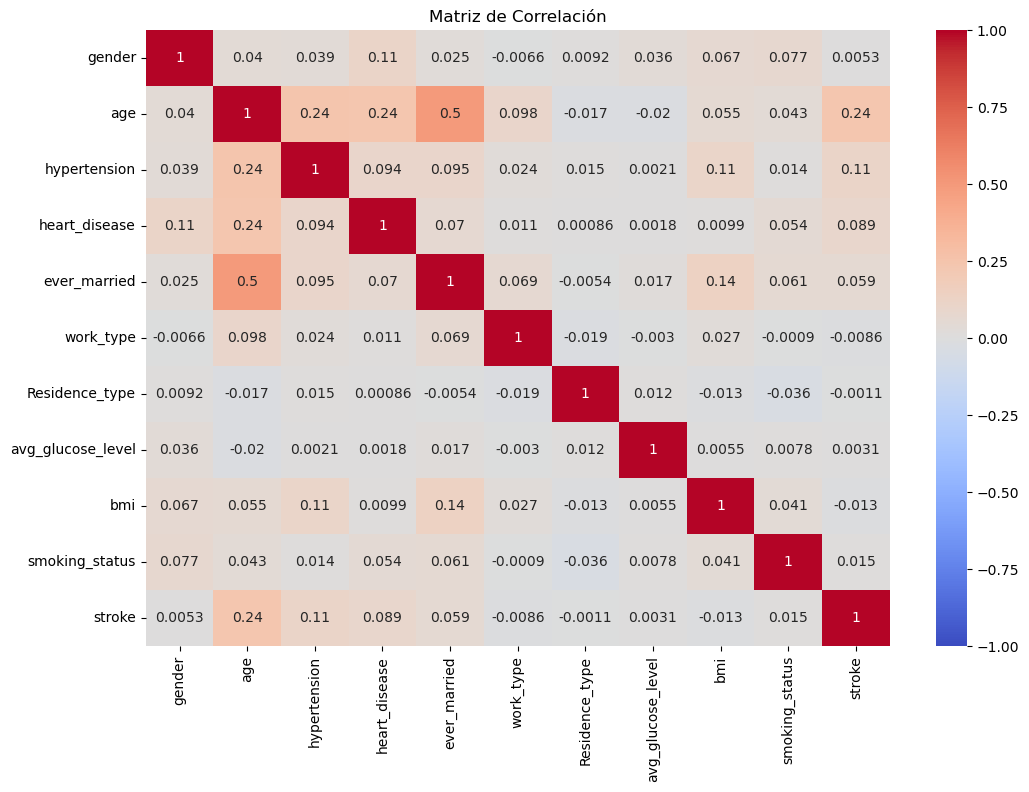

In [427]:
matriz_correlacion = df_normalizada.corr()
plt.figure(figsize=(12,8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1) #Mapa de calor para visualizar las correlaciones
plt.title('Matriz de Correlación')
plt.show()

Observando la matriz y el análisis de datos previo podemos concluir que probablmente las variables más importantes para determinar las posibilidades de un accidente cerebrovascular sean edad, hipertensión arterial y enfermedades cardíacas.

## Red Neuronal

Tomo como mis datos de entrada edad, presencia de enfermedad cardíaca y presión arterial alta, y mi salida es si sufrió un accidente cerebrovascular, tomo 2/3 de los datos para entrenamiento y un 1/3 para testeo y mi red tiene una capa oculta con 3 neuronas y una salida con 1 neurona, uso la relu como función de activación para la capa oculta, la función logística para la salida y se realiza de manera manual descenso de gradiente estocástico para la optimización de la red.

También se define una función para poder visualizar el ritmo de aprendizaje de la red, se podrá ver en los resultados que en muy pocas iteraciones la red alcanza una precisión rondando el 95%,

In [428]:
def graficar_accuracy(L, train_l, test_l):
    iters = len(test_l)
    fmt_train = {
        'color': 'tab:blue',
        'ls': 'solid',
        'lw': 3,
    }

    fmt_test = {
        'color': 'tab:orange',
        'ls': 'solid',
        'lw': 3,
    }

    fig, (ax) = plt.subplots(1,1,figsize=(10,8))
    ax.plot(train_l, label='Train', **fmt_train)
    ax.plot(test_l, label='test', **fmt_test)

    ax.grid(which='both')
    ax.legend()
    ax.set_title(f'Accuracy {L=}')
    ax.set_xlabel('Step')

    fig.tight_layout()
    plt.savefig(f'accuracy_{L=}_{iters=}.png')
    plt.show()

Precisión conjunto de entrenamiento: 95.56%
Precisión en el conjunto de prueba: 95.35%


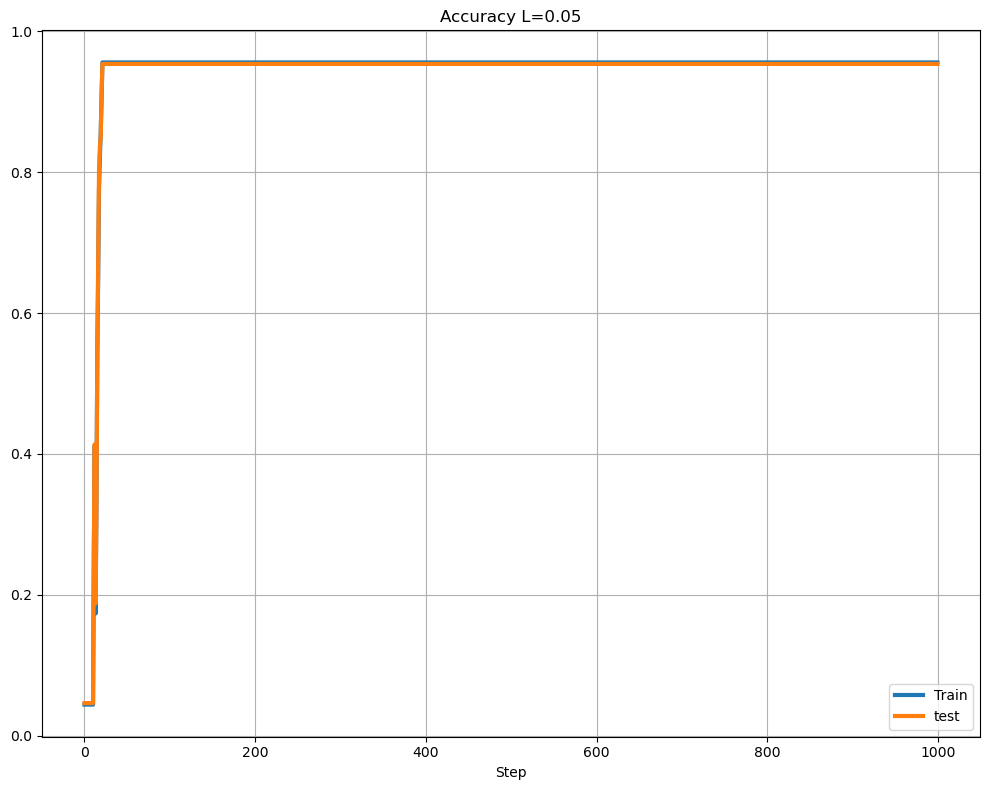

In [429]:
train_l = []
test_l = []
df_inputs = pd.concat([df_normalizada['age'], df[['heart_disease', 'hypertension']]], axis=1) #Tomo los datos normalizados de edad, y los datos binarios de hypertension y heart_disease
L = 0.05 #Tasa de aprendizaje
input_size = 3 #Variables de entrada
hidden_size = 3 #Tamaño capa oculta
output_size = 1 #Tamaño salida

X = df_inputs.values
Y = df_outputs.values.reshape(-1, 1)

def train_test_split(X, Y, test_size=1/3, random_state=None): #Defino función para separar mis datos de entrenamiento y testeo
    if random_state:
        np.random.seed(random_state)

    #Mezclar los datos
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    X = X[indices]
    Y = Y[indices]

    #Calcular tamaño del conjunto de prueba
    test_size = int(X.shape[0]*test_size)

    #Dividr los datos
    X_train, X_test = X[:-test_size], X[-test_size:]
    Y_train, Y_test = Y[:-test_size], Y[-test_size:]

    return X_train, X_test, Y_train, Y_test

#Dividir el conjunto de datos
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, random_state=20)

# Construir red neuronal con pesos y sesgos
# inicializados aleatoriamente
w_hidden = np.random.rand(hidden_size, input_size)
w_output = np.random.rand(output_size, hidden_size)

b_hidden = np.random.rand(hidden_size, 1)
b_output = np.random.rand(output_size, 1)

# Funciones de activación
def relu(x):
    return np.maximum(0, x)

def logistic(x):
    return 1 / (1 + np.exp(-x))

# Ejecutar entradas a través de la red neuronal para obtener salidas predichas
def forward_prop(X):
    Z1 = np.dot(w_hidden, X) + b_hidden
    A1 = relu(Z1)
    Z2 = np.dot(w_output, A1) + b_output
    A2 = logistic(Z2)
    return Z1, A1, Z2, A2

# Derivadas de las funciones de activación
def d_relu(x):
    return np.where(x > 0, 1, 0)

def d_logistic(x):
    sig = logistic(x)
    return sig * (1 - sig)

# Devuelve pendientes para pesos y sesgos
# usando la regla de la cadena
def backward_prop(Z1, A1, Z2, A2, X, Y):
    m = X.shape[1]

    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    dB2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(w_output.T, dZ2)
    dZ1 = dA1 * d_relu(Z1)
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    dB1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, dB1, dW2, dB2

# Predecir
def predict(X):
    _, _, _, A2 = forward_prop(X.T)
    return A2 > 0.5  # Devuelve 1 si la probabilidad es mayor que 0.5

def calcular_precision(Y_true, Y_pred):
    return np.mean(Y_true == Y_pred)

# Ejecutar descenso de gradiente
for i in range(1000):
    # seleccionar aleatoriamente uno de los datos de entrenamiento
    idx = np.random.choice(X_train.shape[0], 1, replace=False)
    X_sample = X_train[idx].T
    Y_sample = Y_train[idx].reshape(1, 1)

    # pasar datos seleccionados aleatoriamente a través de la red neuronal
    Z1, A1, Z2, A2 = forward_prop(X_sample)

    # distribuir error a través de la retropropagación
    # y devolver pendientes para pesos y sesgos
    dW1, dB1, dW2, dB2 = backward_prop(Z1, A1, Z2, A2, X_sample, Y_sample)

    # actualizar pesos y sesgos
    w_hidden -= L * dW1
    b_hidden -= L * dB1
    w_output -= L * dW2
    b_output -= L * dB2

    #Listas
    Y_train_pred = predict(X_train)
    train_accuracy = calcular_precision(Y_train, Y_train_pred)
    train_l.append(train_accuracy)

    Y_test_pred = predict(X_test)
    test_accuracy = calcular_precision(Y_test, Y_test_pred)
    test_l.append(test_accuracy)

# Evaluar precisión de entrenamiento
Y_train_pred = predict(X_test)
train_accuracy = calcular_precision(Y_train, Y_train_pred)
print(f'Precisión conjunto de entrenamiento: {train_accuracy * 100:.2f}%')

# Evaluar precisión en el conjunto de prueba
Y_test_pred = predict(X_test)
test_accuracy = calcular_precision(Y_test, Y_test_pred)
print(f'Precisión en el conjunto de prueba: {test_accuracy * 100:.2f}%')

graficar_accuracy(L, train_l, test_l)

### Modelo de red scikit-learn

Creamos una red usando las librerías de scikit-learn que imite nuestra red manual para realizar al comparativa en los resultados.

In [430]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

#Tomo los datos normalizados de edad, y los datos binarios de hypertension y heart_disease
df_inputs = pd.concat([df_normalizada['age'], df[['heart_disease', 'hypertension']]], axis=1) 
df_outputs = df['stroke'] 

X = df_inputs.values
Y = df_outputs.values

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3, random_state=20)

# Crear el modelo de red neuronal
mlp = MLPClassifier(hidden_layer_sizes=(3,),  # Tamaño de la capa oculta
                    activation='relu',        # Función de activación
                    solver='sgd',            # Algoritmo de optimización
                    learning_rate_init=0.05,  # Tasa de aprendizaje
                    max_iter=1000,            # Número máximo de iteraciones
                    random_state=1)

# Entrenar el modelo
mlp.fit(X_train, Y_train)

# Realizar predicciones
Y_train_pred = mlp.predict(X_train)
Y_test_pred = mlp.predict(X_test)

# Calcular precisión
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)

print(f'Precisión conjunto de entrenamiento: {train_accuracy * 100:.2f}%')
print(f'Precisión en el conjunto de prueba: {test_accuracy * 100:.2f}%')

Precisión conjunto de entrenamiento: 95.46%
Precisión en el conjunto de prueba: 95.56%


# Conclusión

En este proyecto se ha realizado un modelo de red neuronal para predecir accidentes cerebrovasculares, identificando las características clave a partir del análisis de datos y posteriormente aplicando tanto un modelo manual y un modelo usando la librería scikit-learn.

Ambos conjuntos dieron resultados similares ronndando entre un 95% y un 95.5%, tanto en los conjuntos de entrenamiento como los conjuntos de prueba, demostrando efectivamente la alta relevancia de los datos de entrada tomados a partir del análisis de datos y que los modelos generalizan de manera correcta ante nuevos datos.